In [1]:
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pylab as plt
import matplotlib, sys, os, pickle
import numpy as np
import sys

# Import local version of shap
sys.path.insert(0, "/homes/gws/hughchen/per_ref_shap/shap")
import shap

from deepshap.data import load_nhanes_new
from model import model_pred, models_pred, fit_xgb, fit_mlp, fit_gbc

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_nhanes_new(is_cycle_split=False, val_size=0.5)

# Drop release cycle
X_train = X_train.drop(columns=["Demographics_ReleaseCycle", "Dietary_DSDuration"])
X_valid = X_valid.drop(columns=["Demographics_ReleaseCycle", "Dietary_DSDuration"])
X_test  = X_test.drop(columns=["Demographics_ReleaseCycle", "Dietary_DSDuration"])

num_mlp = 5
np.random.seed(1209)
random_states = np.random.choice(1000,num_mlp,replace=False)
rs_ind = 0; models = []

# Train MLP models
print("\nIndividual model prediction (Test ROC AUC)\n" + "#"*30)
for i in range(num_mlp):
    X_train2, y_train2 = resample(X_train, y_train, random_state=random_states[rs_ind])
    mname = "mlp_{}.h5".format(random_states[rs_ind])
    model = fit_mlp(X_train2, y_train2, mname=mname, eta=0.005)
    print(round(roc_auc_score(y_train2, model_pred(model, X_train2)),4))
    models.append(model)
    rs_ind += 1

# Get predictions for valid and test set
valid_preds = models_pred(models, X_valid)
test_preds  = models_pred(models, X_test)

# Get test set performance
print("\nIndividual model prediction (Test ROC AUC)\n" + "#"*30)
for i in range(test_preds.shape[1]):
    print(round(roc_auc_score(y_test, test_preds[:,i]),4))


Individual model prediction (Test ROC AUC)
##############################
0.8434
0.5347
0.8537
0.5176
0.8404

Individual model prediction (Test ROC AUC)
##############################
0.8207
0.5292
0.833
0.5042
0.8331


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

model_inds   = range(num_mlp)
X_valid_meta = valid_preds[:,model_inds]
X_test_meta  = test_preds[:,model_inds]

print("Average ensemble")
print(roc_auc_score(y_test,test_preds[:,model_inds].mean(1)))

print("Stacked Generalization (logistic reg)")
lin_meta_model = LogisticRegression(random_state=0)
lin_meta_model.fit(X_valid_meta, y_valid)
print(roc_auc_score(y_test,lin_meta_model.predict_proba(X_test_meta)[:,1]))

print("Stacked Generalization (sklearn DTC)")
dtc_meta_model = DecisionTreeClassifier(random_state=0)
dtc_meta_model.fit(X_valid_meta, y_valid)
print(roc_auc_score(y_test,dtc_meta_model.predict_proba(X_test_meta)[:,1]))

print("Stacked Generalization (sklearn RFC)")
rfc_meta_model = RandomForestClassifier(random_state=0)
rfc_meta_model.fit(X_valid_meta, y_valid)
print(roc_auc_score(y_test,rfc_meta_model.predict_proba(X_test_meta)[:,1]))

print("Stacked Generalization (sklearn GBC)")
gbc_meta_model = GradientBoostingClassifier(random_state=0)
gbc_meta_model.fit(X_valid_meta, y_valid)
print(roc_auc_score(y_test,gbc_meta_model.predict_proba(X_test_meta)[:,1]))

Average ensemble
0.8405293996974126
Stacked Generalization (logistic reg)
0.8424748156169805
Stacked Generalization (sklearn DTC)
0.5859830687173175
Stacked Generalization (sklearn RFC)
0.7979277498663605
Stacked Generalization (sklearn GBC)
0.8444390939342474


The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


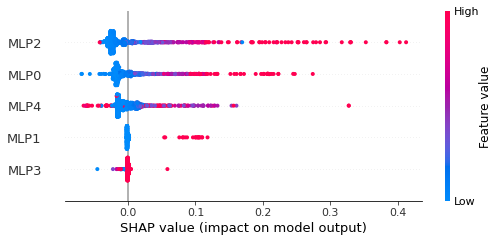

In [3]:
np.random.seed(24909)
expli_inds = np.random.choice(range(X_test_meta.shape[0]), 1000)
refer_inds = np.random.choice(range(X_valid_meta.shape[0]), 100)
expli_meta = X_test_meta[expli_inds]
refer_meta = X_valid_meta[refer_inds]
explicand  = X_test.iloc[expli_inds].values
reference  = X_valid.iloc[refer_inds].values

# Explain avg bagging model
avg_meta_attr = (1/expli_meta.shape[1])*(expli_meta - refer_meta.mean(0))
plt.clf()
shap.summary_plot(avg_meta_attr, expli_meta, [f"MLP{i}" for i in range(5)], show=False)
plt.savefig("fig/avg_meta_summary.pdf")

# Explain logistic meta-model (convert to probability explanation)
lin_meta_attr_per_marg = (expli_meta[:,None,:] - refer_meta[None,:,:]) * lin_meta_model.coef_[None, :]

expli_prob = lin_meta_model.predict_proba(expli_meta)[:,1]
refer_prob = lin_meta_model.predict_proba(refer_meta)[:,1]
expli_marg = expli_meta @ lin_meta_model.coef_.T[:,0]
refer_marg = refer_meta @ lin_meta_model.coef_.T[:,0]
numer   = (expli_prob[:,None] - refer_prob[None,:])
denom   = (expli_marg[:,None] - refer_marg[None,:])
rescale = (numer/denom)

lin_meta_attr_per_prob = lin_meta_attr_per_marg*rescale[:,:,None]
lin_meta_attr_prob = lin_meta_attr_per_prob.mean(1)

plt.clf()
shap.summary_plot(lin_meta_attr_prob, expli_meta, [f"MLP{i}" for i in range(5)], show=False)
plt.savefig("fig/lin_meta_summary.pdf")

# Explain tree meta-model
gbc_meta_expl = shap.TreeExplainer(gbc_meta_model, refer_meta, model_output="probability")
gbc_meta_attr = gbc_meta_expl.shap_values(expli_meta)
plt.clf()
shap.summary_plot(gbc_meta_attr, expli_meta, [f"MLP{i}" for i in range(5)], show=False)
plt.savefig("fig/gbc_meta_summary.pdf")

(array([  2.,   0., 978.,   0.,   0.,   0.,   0.,   0.,   0.,  20.]),
 array([-0.01668083, -0.00913162, -0.00158242,  0.00596679,  0.01351599,
         0.0210652 ,  0.0286144 ,  0.03616361,  0.04371281,  0.05126202,
         0.05881122], dtype=float32),
 <a list of 10 Patch objects>)

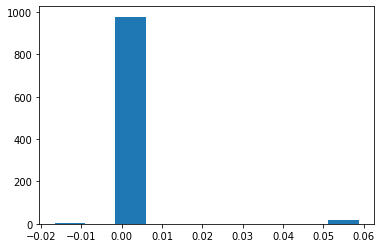

In [14]:
plt.hist(avg_meta_attr[:,1])

(array([ 11.,   3.,   5.,   1.,   0.,   0.,   0., 978.,   1.,   1.]),
 array([-0.07078739, -0.06169244, -0.05259749, -0.04350254, -0.03440759,
        -0.02531264, -0.01621769, -0.00712274,  0.00197221,  0.01106716,
         0.02016211]),
 <a list of 10 Patch objects>)

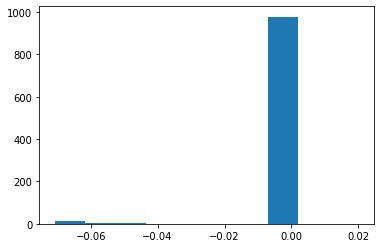

In [15]:
plt.hist(lin_meta_attr_prob[:,1])

### Attribution for average is the sum or all attributions times 1/5

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


keras is no longer supported, please use tf.keras instead.


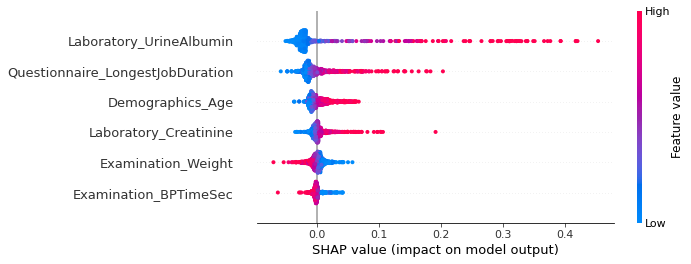

In [4]:
deep_attr_lst = []
count = 0
for model in models:
    explainer = shap.DeepExplainer(model, reference)
    deep_attr = explainer.shap_values(explicand, per_reference=True)[0]
    deep_attr_lst.append(deep_attr)
    plt.clf()
    shap.summary_plot(deep_attr.mean(1), explicand, X_train.columns, max_display=6, show=False)
    plt.savefig("fig/mlp{}_summary.pdf".format(count))
    count += 1

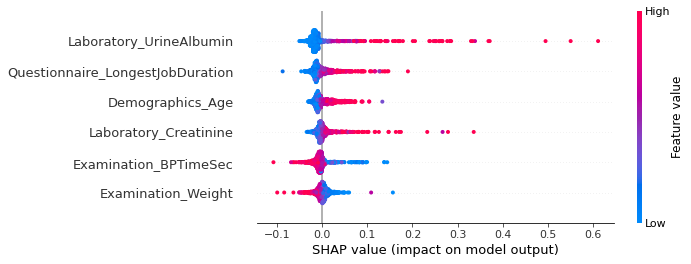

In [5]:
# Average ensemble
avg_meta_attr_x = np.array(deep_attr_lst).mean(2).mean(0) # Average across models and reference
plt.clf()
shap.summary_plot(avg_meta_attr_x, explicand, X_train.columns, max_display=6, show=False)
plt.savefig("fig/avg_summary.pdf")

# Linear meta model
expli_prob = lin_meta_model.predict_proba(expli_meta)[:,1]
refer_prob = lin_meta_model.predict_proba(refer_meta)[:,1]
expli_marg = expli_meta @ lin_meta_model.coef_.T[:,0]
refer_marg = refer_meta @ lin_meta_model.coef_.T[:,0]
numer   = (expli_prob[:,None] - refer_prob[None,:])
denom   = (expli_marg[:,None] - refer_marg[None,:])
rescale = (numer/denom)
beta = lin_meta_model.coef_[0,:]
lin_meta_attr_x = ((np.array(deep_attr_lst) * beta[:,None,None,None]).sum(0) * rescale[:,:,None]).mean(1)
plt.clf()
shap.summary_plot(lin_meta_attr_x, explicand, X_train.columns, max_display=6 , show=False)
plt.savefig("fig/lin_summary.pdf")

# GBC meta model
safe_div = lambda a,b : np.divide(a, b, out=np.zeros_like(a), where=b!=0)
gbc_meta_attr_per = gbc_meta_expl.shap_values(expli_meta, per_reference=True)
gbc_meta_attr_per = np.swapaxes(gbc_meta_attr_per, 0, 1)
rescale = safe_div(gbc_meta_attr_per,np.array(deep_attr_lst).sum(3))
gbc_meta_attr_x = (np.array(deep_attr_lst) * rescale[:,:,:,None]).sum(0).mean(1)
plt.clf()
shap.summary_plot(gbc_meta_attr_x, explicand, X_train.columns, max_display=6 , show=False)
plt.savefig("fig/gbc_summary.pdf")

In [ ]:
col_ind = list(X_train.columns).index("Laboratory_UrineAlbumin")
shap.dependence_plot(col_ind, lin_meta_attr_x, explicand, X_train.columns)
shap.dependence_plot(col_ind, gbc_meta_attr_x, explicand, X_train.columns)

In [ ]:
[f for f in X_train.columns if "JobDura" in f]

In [ ]:
col_ind = list(X_train.columns).index("Laboratory_UrineAlbumin")
# col_ind = list(X_train.columns).index("Questionnaire_LongestJobDuration")
shap.dependence_plot(col_ind, lin_meta_attr_x, explicand, X_train.columns)
shap.dependence_plot(col_ind, gbc_meta_attr_x, explicand, X_train.columns)